In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
torch.cuda.set_device(0)
torch.cuda.current_device()

import warnings
from pathlib import Path
from fairseq_transformer_wrapper import FairseqTransformerHub, parse_single_alignment

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import logging
logger = logging.getLogger()
logger.setLevel('WARNING')

from dotenv import load_dotenv
load_dotenv()
device = "cuda" if torch.cuda.is_available() else "cpu"

/home/usuaris/veu/belen.alastruey/miniconda3/envs/int_nmt/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-03-03 15:52:54 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX


In [3]:
europarl_dir = Path(os.environ['EUROPARL_DATA_DIR'])
ckpt_dir = Path(os.environ['EUROPARL_CKPT_DIR'])

#iwslt14_dir = Path(os.environ['IWSLT14_DATA_DIR'])
#ckpt_dir = Path(os.environ['IWSLT14_CKPT_DIR'])

### Alignment test (BPE from Europarl)
test_de_bpe = europarl_dir / "processed_data/test.bpe.de"
test_de_word =  europarl_dir / "processed_data/test.de"
test_en_bpe = europarl_dir / "processed_data/test.bpe.en"
test_en_word = europarl_dir / "processed_data/test.en"
gold_alignment = europarl_dir / "gold_alignment/alignment.talp"

### IWSLT14 test
#test_de_bpe = iwslt14_dir / "test.de"
#test_de_word = iwslt14_dir / "tmp/test.de"
#test_en_bpe = iwslt14_dir / "test.en"
#test_en_word = iwslt14_dir / "tmp/test.en"

warnings.simplefilter('ignore')

with open(test_de_bpe, encoding="utf-8") as fbpe:
    src_bpe_sents = fbpe.readlines()
with open(test_en_bpe, encoding="utf-8") as fbpe:
    tgt_bpe_sents = fbpe.readlines()
with open(europarl_dir / "data_in_progress/test.uc.de", encoding="utf-8") as fword:
    src_word_sents = fword.readlines()
with open(europarl_dir / "data_in_progress/test.uc.en", encoding="utf-8") as fword:
    tgt_word_sents = fword.readlines()


model_type = 'baseline'
suffix = '_q_self_attn_head' #'_q_wandb'
seed = 2253                  # 1234

if model_type == 'baseline':
    suffix=''

hub = FairseqTransformerHub.from_pretrained(
    ckpt_dir / f"{model_type}/{seed}",
    checkpoint_file=f"checkpoint_best{suffix}.pt",
    data_name_or_path=(europarl_dir / "processed_data/fairseq_preprocessed_data").as_posix(),
    #(data_name_or_path=iwslt14_dir / "data-bin").as_posix(),
)
num_layers = 6
eos_id = hub.tgt_dict.index("</s>")

In [4]:
# for i in range(400):
# #i=0
#     src_sent, src_tok, src_tensor, tgt_sent, tgt_tok, tgt_tensor = hub.get_sample('test', i)
#     print(i)
#     print(f"\nSource sentence: \t {src_sent}")
#     print(f"Target sentence: \t {tgt_sent}")

In [103]:
# Gold alignment data
i = 10 #3
src_word_sent = src_word_sents[i]
print(src_word_sent)
tgt_word_sent = tgt_word_sents[i]
print(tgt_word_sent)

src_tok_str = src_bpe_sents[i].strip()
src_tok = src_tok_str.split()

tgt_tok_str = tgt_bpe_sents[i].strip()
tgt_tok = tgt_tok_str.split()
src_tensor = torch.tensor([hub.src_dict.index(t) for t in src_tok_str.split()] + [eos_id])#.to(device)
#src_tensor = torch.tensor([hub.tgt_dict.index("<unk>") for t in src_tok_str.split()] + [eos_id])#.to(device)


tgt_tensor = torch.tensor([hub.tgt_dict.index(t) for t in tgt_tok_str.split()] + [eos_id])#.to(device)

Europa macht es eine Nummer zu groß , wenn es eine allgemeine Regelung der Gesundheitspolitik anstrebt .

Europe should not get over ambitious by trying to manage public health policy .



In [104]:
# Test data
# i = 148 # 0, 1 28, 45, 148 (pred_tok vs tgt_tok), 178, 16 (Hallucination)

# src_sent, src_tok, src_tensor, tgt_sent, tgt_tok, tgt_tensor = hub.get_sample('test', i)
# print(f"\nSource sentence: \t {src_sent}")
# print(f"Target sentence: \t {tgt_sent}")


In [105]:
model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)

print("\n\nGREEDY DECODING\n")
pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
pred_tok = hub.decode(pred_tensor, hub.task.tgt_dict)
pred_sent = hub.decode(pred_tensor, hub.task.tgt_dict, as_string=True)
print(f"Predicted sentence: \t {pred_sent}")

print("\n\nBEAM SEARCH\n")
for pred in hub.generate(src_tensor, 5):
    pred_sent = hub.decode(pred['tokens'], hub.task.tgt_dict, as_string=True)
    score = pred['score'].item()
    print(f"{score} \t {pred_sent}")



GREEDY DECODING

Predicted sentence: 	 europe is make be too its enough seeking to regulate health health policy .


BEAM SEARCH

-0.539003312587738 	 europe is making it too big for it to seek to regulate health policy in general .
-0.5430753827095032 	 europe is making it too big to seek to regulate health policy across the board .
-0.5460622310638428 	 europe is making it too big to seek to regulate health policy in general .
-0.5760405659675598 	 europe makes it too big for it to seek to regulate health policy in general .
-0.6839861273765564 	 europe is making it too big for it to aim for a general regulation of health .


In [106]:
probs = torch.nn.functional.softmax(log_probs, dim=-1)
print('probs',probs.size())
pred_ind = torch.argmax(probs,dim=-1)
print(pred_ind.size())
pred = torch.max(probs,dim=-1)
pred


probs torch.Size([15, 10001])
torch.Size([15])


torch.return_types.max(
values=tensor([0.8425, 0.4456, 0.2785, 0.1972, 0.5218, 0.5043, 0.4333, 0.3339, 0.8897,
        0.3613, 0.5833, 0.9594, 0.3870, 0.7011, 0.9060], device='cuda:0',
       grad_fn=<MaxBackward0>),
indices=tensor([2518,   54,  482,   50,  643,  295, 1733, 3424,   28, 5339,  880,  880,
         392,   24,    2], device='cuda:0'))

## Local analysis

### Cross-attention per layer (local)

Added the residual connection contribution as RES. Only the output of the encoder is considered (no rollout).

mean residual 0.9587316 std 0.049192164


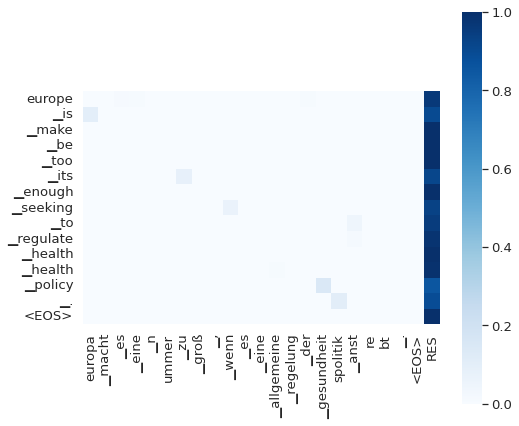

In [107]:
layer = 0

corss_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.encoder_attn'])#encoder.self_attn
corss_attn_contributions = corss_attn_contributions.detach().cpu().numpy()
plt.figure(figsize=(8,8))

df = pd.DataFrame(corss_attn_contributions[layer],columns=src_tok + ['<EOS>'] + ['RES'],index=pred_tok + ['<EOS>'])
sns.set(font_scale=1.2)
sns.heatmap(df,cmap="Blues",square=True)#Reds,,center=0
plt.gcf().subplots_adjust(bottom=0.2)
print('mean residual',df['RES'].mean(), 'std', df['RES'].std())

### Self-attention decoder per layer (local)

torch.Size([6, 15, 15])


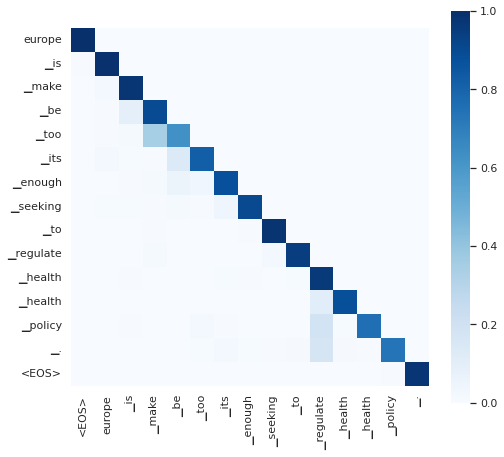

In [108]:
layer = 4
self_attn_dec_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.self_attn'])#encoder.self_attn
print(self_attn_dec_contributions.size())
plt.figure(figsize=(8,8))
self_attn_dec_contributions = self_attn_dec_contributions.detach().cpu().numpy()
df = pd.DataFrame(self_attn_dec_contributions[layer],columns= ['<EOS>'] + pred_tok, index=pred_tok + ['<EOS>'])
sns.set(font_scale=1)
sns.heatmap(df,cmap="Blues",square=True)#Reds,,center=0
plt.gcf().subplots_adjust(bottom=0.2)


### Cross + self-attention per layer (local)

We multiply the contributions of the decoder self-attention by the value of RES, and concatenate.

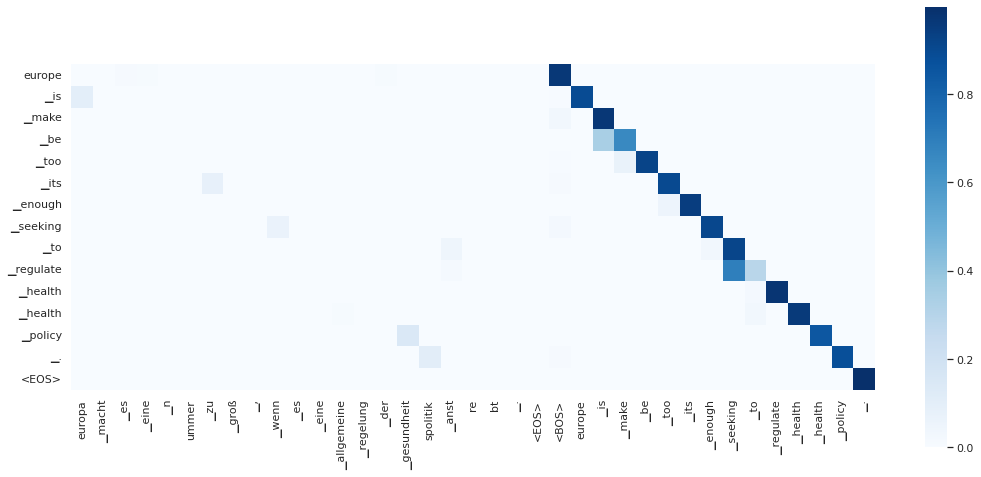

In [109]:
layer = 0
self_dec_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.self_attn'])#encoder.self_attn
cross_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.encoder_attn'])#encoder.self_attn
cross_contributions_layer = cross_contributions[layer]

self_dec_contributions_layer = (self_dec_contributions[layer].transpose(0,1)*cross_contributions_layer[:,-1]).transpose(0,1)
cross_contributions_layer = cross_contributions_layer[:,:-1]
final_cross_contributions = torch.cat((cross_contributions_layer,self_dec_contributions_layer),dim=1)
final_cross_contributions_np = final_cross_contributions.detach().cpu().numpy()
plt.figure(figsize=(18,9))
df = pd.DataFrame(final_cross_contributions_np, columns = src_tok + ['<EOS>'] + ['<BOS>'] + pred_tok, index = pred_tok + ['<EOS>'])
sns.set(font_scale=1)
sns.heatmap(df,cmap="Blues",square=True)#Reds,,center=0
plt.gcf().subplots_adjust(bottom=0.2)



## Global analysis

### Rollout of the encoder

In [110]:
def compute_joint_attention(att_mat):
    """ Compute attention rollout given contributions or attn weights + residual."""

    aug_att_mat =  att_mat
    device = att_mat.device
    joint_attentions = torch.zeros(aug_att_mat.size()).to(device)

    layers = joint_attentions.shape[0]
    joint_attentions[0] = aug_att_mat[0]
    
    for i in np.arange(1,layers):
        joint_attentions[i] = torch.matmul(aug_att_mat[i],joint_attentions[i-1])
        
    return joint_attentions

# Compute contributions rollout encoder self-attn
enc_self_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['encoder.self_attn'])#encoder.self_attn
enc_self_attn_contributions_mix = compute_joint_attention(enc_self_attn_contributions)

# Get last layer relevances w.r.t input
relevances_enc_self_attn = enc_self_attn_contributions_mix[-1]
# repeat num_layers times
relevances_enc_self_attn = relevances_enc_self_attn.unsqueeze(0).repeat(num_layers, 1, 1)

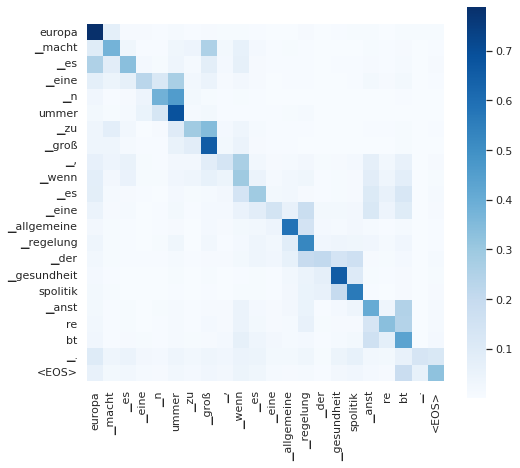

In [111]:
# Encoder self-attention relevances (last layer)
plt.figure(figsize=(8,8))
df = pd.DataFrame(relevances_enc_self_attn[-1].cpu().detach().numpy(),columns=src_tok + ['<EOS>'], index=src_tok + ['<EOS>'])
sns.set(font_scale=1)
sns.heatmap(df,cmap="Blues",square=True)#Reds,,center=0
plt.gcf().subplots_adjust(bottom=0.2)

In [112]:
def compute_joint_attention_nmt(att_mat, src_len):
    """ Contributions rollout whole Transformer-NMT model"""

    aug_att_mat =  att_mat
    device = att_mat.device
    joint_attentions = torch.zeros(aug_att_mat.size()).to(device)

    layers = joint_attentions.shape[0]
    joint_attentions[0] = aug_att_mat[0]
    #s[0] = joint_attentions[0] / joint_attentions[0].sum(dim=-1,keepdim=True)
    
    for l in np.arange(1,layers):
        #print('aug_att_mat[l]', aug_att_mat[l])
        for i in np.arange(0,aug_att_mat.size(1)):
            for j in np.arange(0,aug_att_mat.size(2)):
                # print('aug_att_mat[l,i,src_len:src_len+i+1]',aug_att_mat[l,i,src_len:src_len+i+1])
                # print('joint_attentions[l-1,0:i+1,j])', joint_attentions[l-1,0:i+1,j])
                if j < src_len:
                    # Sum C^l_{i,j} only when measuring contributions of source (j<src_len)
                    joint_attentions[l,i,j] = torch.dot(aug_att_mat[l,i,src_len:],joint_attentions[l-1,:,j]) + aug_att_mat[l,i,j]
                    #joint_attentions[l,i,j] = torch.dot(aug_att_mat[l,i,src_len:src_len+i+1],joint_attentions[l-1,0:i+1,j]) + aug_att_mat[l,i,j]
                    
                else:
                    joint_attentions[l,i,j] = torch.dot(aug_att_mat[l,i,src_len:],joint_attentions[l-1,:,j])
                    #joint_attentions[l,i,j] = torch.dot(aug_att_mat[l,i,src_len:src_len+i+1],joint_attentions[l-1,0:i+1,j])
                
        joint_attentions[l] = joint_attentions[l] / joint_attentions[l].sum(dim=-1,keepdim=True)
                #print(joint_attentions[l,i,j])
        
    return joint_attentions

In [113]:
def rollout(C, C_enc_out):
    """ Contributions rollout whole Transformer-NMT model, Gerard's approach
    C: [cross_attn;self_dec_attn] before encoder rollout
    C_enc_out: encoder rollout last layer
    """
    src_len = C.size(2) - C.size(1)
    tgt_len = C.size(1)

    C_sa_roll = C[:, :, -tgt_len:]     # Self-att, only has 1 layer (last)
    C_ed_roll = torch.einsum(          # encoder rollout*cross-attn
        "lie , ef -> lif",
        C[:, :, :src_len],             # Cross-att
        C_enc_out                      # Encoder rollout
    )

    C_roll = torch.cat([C_ed_roll, C_sa_roll], dim=-1) # [(cross_attn*encoder rollout);self_dec_attn]
    C_roll_new_accum = C_roll[0].unsqueeze(0)

    for i in range(1, len(C)):
        C_sa_roll_new = torch.einsum(
            "ij , jk -> ik",
            C_roll[i, :, -tgt_len:],   # Self-att dec
            C_roll_new_accum[i-1, :, -tgt_len:], # Self-att (prev. roll)
        )
        C_ed_roll_new = torch.einsum(
            "ij , jk -> ik",
            C_roll[i, :, -tgt_len:],  # Self-att dec
            C_roll_new_accum[i-1, :, :src_len], # Cross-att (prev. roll)
        ) + C_roll[i, :, :src_len]    # Cross-att

        C_roll_new = torch.cat([C_ed_roll_new, C_sa_roll_new], dim=-1)
        C_roll_new = C_roll_new / C_roll_new.sum(dim=-1,keepdim=True)
        
        C_roll_new_accum = torch.cat([C_roll_new_accum, C_roll_new.unsqueeze(0)], dim=0)
        

    return C_roll_new_accum

### Gerard's approach

In [114]:
# Compute joint cross + self attention
self_dec_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.self_attn'])#encoder.self_attn
cross_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.encoder_attn'])#encoder.self_attn
self_dec_contributions = (self_dec_contributions.transpose(1,2)*cross_contributions[:,:,-1].unsqueeze(1)).transpose(1,2)
joint_self_cross_contributions = torch.cat((cross_contributions[:,:,:-1],self_dec_contributions),dim=-1)

contributions_rollout_gerard = rollout(joint_self_cross_contributions, relevances_enc_self_attn[-1])


### For loops approach

In [115]:
# Compute joint cross + self attention
self_dec_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.self_attn'])#encoder.self_attn
cross_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.encoder_attn'])#encoder.self_attn
self_dec_contributions = (self_dec_contributions.transpose(1,2)*cross_contributions[:,:,-1].unsqueeze(1)).transpose(1,2)

# Original
# Combine encoder self-attention relevances (rollout) with cross-attention contributions
cross_contributions = cross_contributions[:,:,:-1]
final_cross_contributions = torch.bmm(cross_contributions, relevances_enc_self_attn[-1].unsqueeze(0).repeat(6,1,1))
joint_self_cross_contributions = torch.cat((final_cross_contributions,self_dec_contributions),dim=-1)
###

# Computing normalized encoder rollout * cross attention
# proportion_cross_source = cross_contributions[:,:,:-1].sum(-1)
# cross_contributions_renorm = cross_contributions[:,:,:-1]
# cross_contributions_renorm = cross_contributions_renorm / (cross_contributions_renorm.sum(dim=-1, keepdim=True) + 0.0001)
# cross_contributions_renorm = torch.bmm(cross_contributions_renorm,relevances_enc_self_attn[-1].unsqueeze(0).repeat(6,1,1))
# final_cross_contributions_renorm = cross_contributions_renorm*proportion_cross_source.unsqueeze(-1)
######

# b) no encoder rollout
#joint_self_cross_contributions = torch.cat((cross_contributions,self_dec_contributions),dim=-1)
# c)
#joint_self_cross_contributions = torch.cat((final_cross_contributions_renorm,self_dec_contributions),dim=-1)
src_len = len(src_tok + ['<EOS>'])
contributions_rollout = compute_joint_attention_nmt(joint_self_cross_contributions, src_len)


In [116]:
torch.all(contributions_rollout_gerard - contributions_rollout < 1e-5)

tensor(True, device='cuda:0')

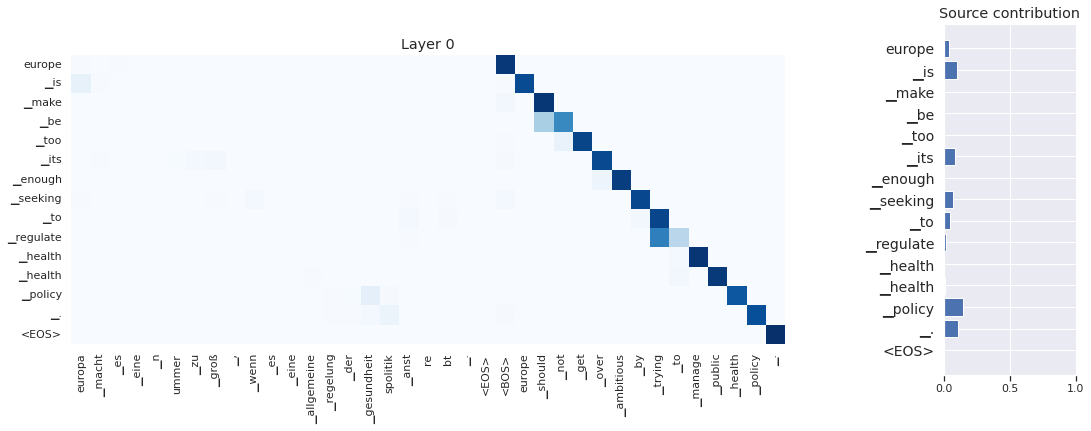

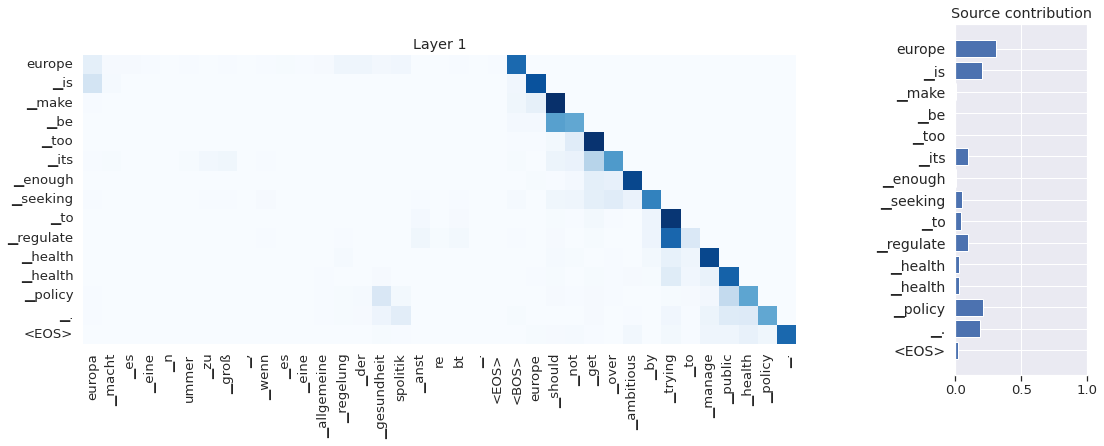

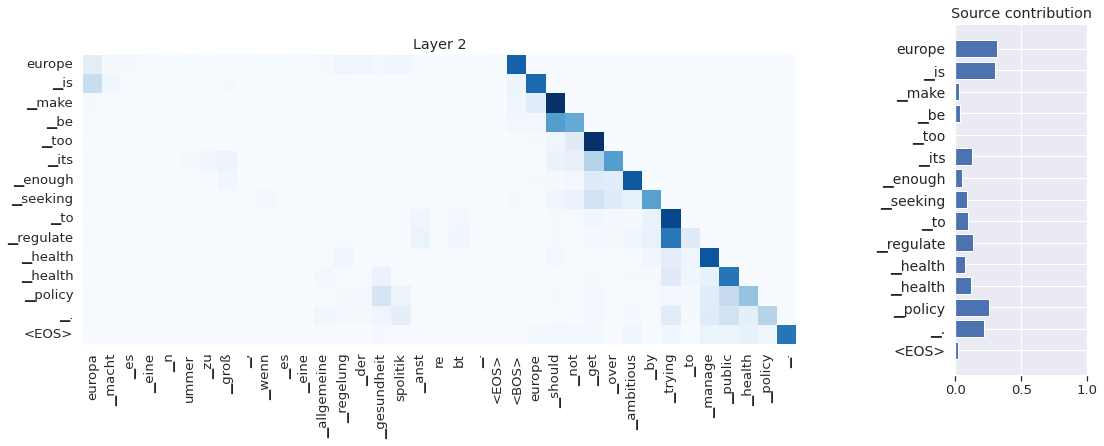

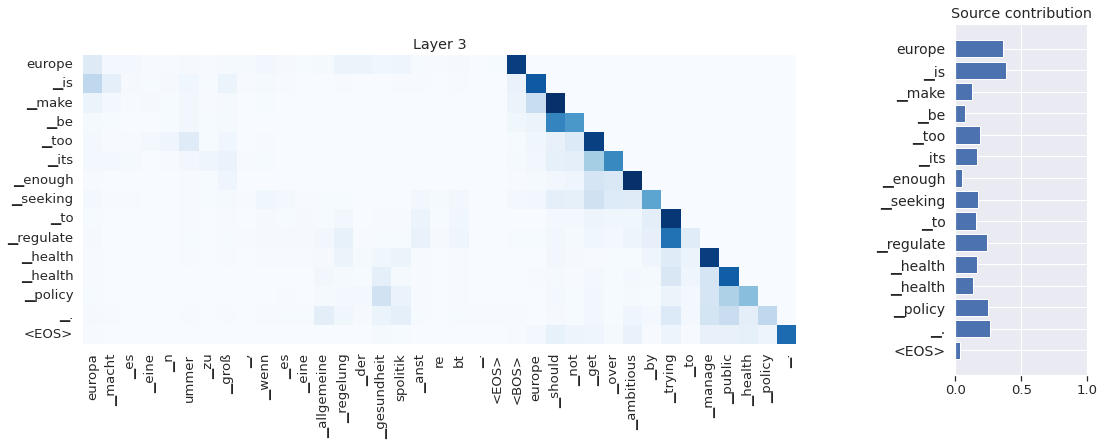

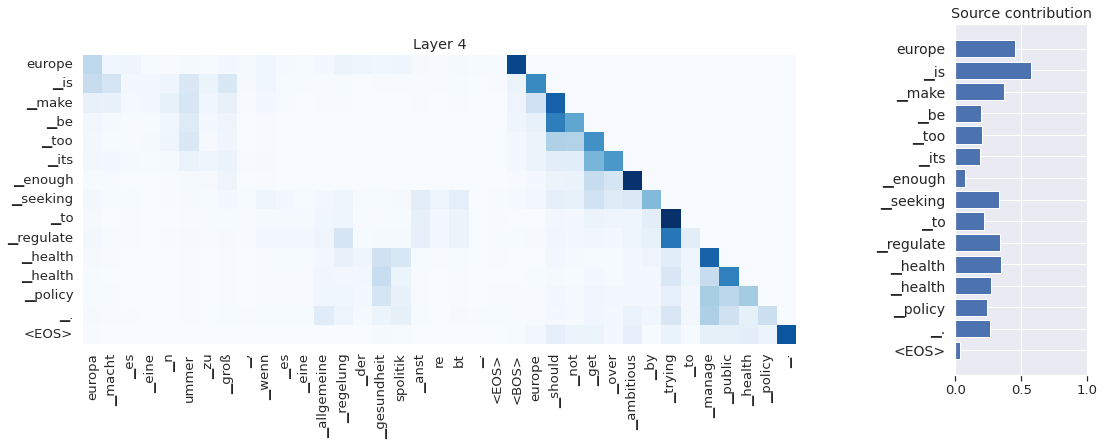

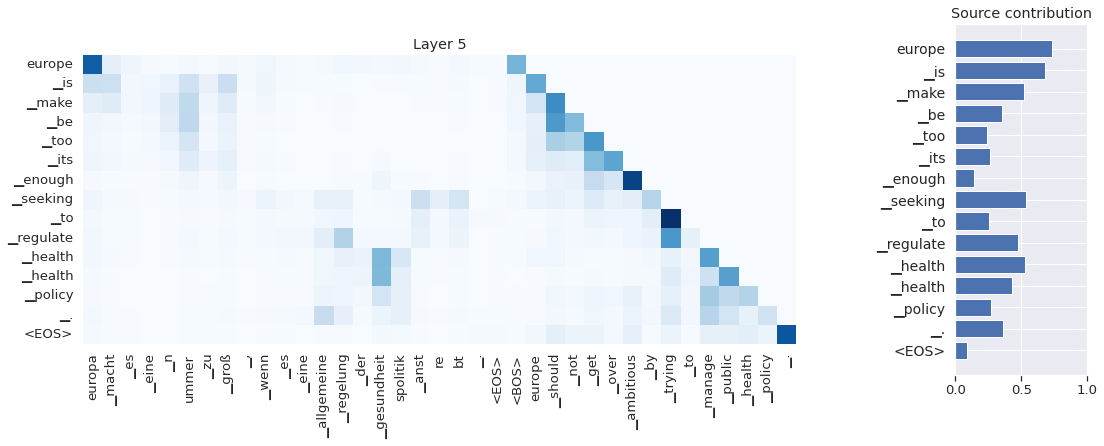

In [117]:
from matplotlib.gridspec import GridSpec

# Cross + self-attention
layer = 0

for layer in range(0,num_layers):

    fig = plt.figure(figsize=(18, 20))
    gs = GridSpec(3, 4)
    gs.update(wspace=1.2, hspace=0.05)#0.015
    ax_main = plt.subplot(gs[0:3, :3])
    ax_yDist = plt.subplot(gs[1, 3])#, sharey=ax_main)
    
    contributions_rollout_layer = contributions_rollout[layer]
    contributions_rollout_layer_np = contributions_rollout_layer.detach().cpu().numpy()
    df = pd.DataFrame(contributions_rollout_layer_np, columns = src_tok + ['<EOS>'] + ['<BOS>'] + tgt_tok, index = pred_tok + ['<EOS>'])
    sns.set(font_scale=1.2)
    sns.heatmap(df,cmap="Blues",square=True,ax=ax_main,cbar=False)#Reds,center=0
    src_contribution = contributions_rollout_layer_np[:,:len(src_tok)].sum(-1)
    src_contribution
    df_src_contribution = pd.DataFrame(src_contribution, columns = ['src_contribution'], index = tgt_tok + ['<EOS>'])
    #sns.set_style("white")
    ax_yDist.barh(range(0,len(tgt_tok + ['<EOS>'])), df_src_contribution.src_contribution, align='center')
    plt.yticks(ticks = range(0,len(tgt_tok + ['<EOS>'])) ,labels = pred_tok + ['<EOS>'],fontsize='14')
    plt.gca().invert_yaxis()
    plt.grid(visible=True)
    ax_yDist.set_xlim(0,1)

    ax_main.set_title('Layer ' + str(layer))
    ax_yDist.set_title('Source contribution')
    #sns.despine(left=True, bottom=True)
    ax_yDist.xaxis.set_ticks_position("bottom")
    # ax_yDist.xaxis.grid(False)
    # ax_yDist.yaxis.grid(False)
    #plt.gcf().subplots_adjust(bottom=0.2)

In [ ]:
pred

torch.return_types.max(
values=tensor([[0.7575, 0.9716, 0.7258, 0.8246, 0.8891, 0.8772, 0.5150, 0.3701, 0.8733,
         0.9189, 0.8511, 0.8968, 0.9087]], device='cuda:0',
       grad_fn=<MaxBackward0>),
indices=tensor([[9806, 8338,  278,    8,  549,   28, 2362, 4667,   37, 2431,  840,   24,
            2]], device='cuda:0'))

### Gold Alignment

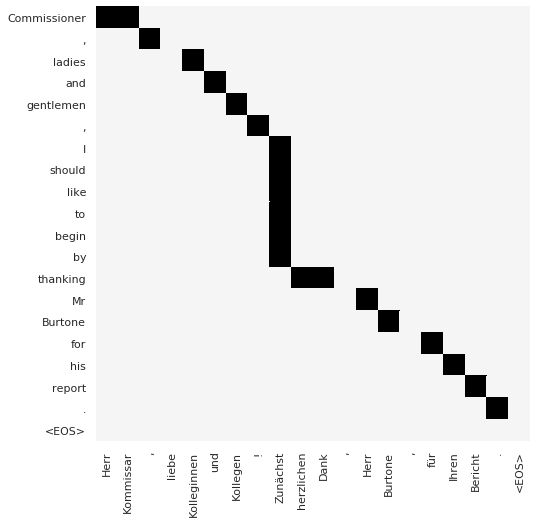

In [18]:
from matplotlib.colors import LinearSegmentedColormap
colors = ["whitesmoke", "gainsboro", "lightgrey", "lightgray", "silver",
            "darkgrey", "darkgray", "grey", "gray", "dimgrey", "dimgray", "black"]
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))

attention_matrix = np.zeros((len(tgt_word_sent.split())+1,len(src_word_sent.split())+1))
with open(gold_alignment, 'r') as f:
    line = f.readlines()[i]
    for alignment_string in line.split():
        t, s = parse_single_alignment(alignment_string, reverse=True)
        attention_matrix[t-1][s-1] = 1
#attention_matrix = attention_matrix[[len(attention_matrix)-1]+list(range(0,len(attention_matrix)-1))]

plt.figure(figsize=(8,8))
fontsize = 10
rotation = 90
df_gold = pd.DataFrame(attention_matrix, columns=src_word_sent.split()+["<EOS>"],index=tgt_word_sent.split()+["<EOS>"])
sns.heatmap(df_gold,cmap=cmap,cbar=False,square=True)
sns.set(font_scale=1)


In [43]:
# for s in hub.task.dataset('test'):
#     src_sent = hub.decode(s['source'], hub.task.src_dict, as_string=True)
#     if 'herr kommissar' in src_sent:
#         print(s['id'])
#         print(src_sent)
#         print('\n')

# OLD ⬇️

In [14]:
transformed_vectors = torch.randn((1,23,23,512))
resultant = torch.randn((1,23,512))
resultant_unsqueeze = resultant.unsqueeze(2)
print('resultant_unsqueeze',resultant_unsqueeze.size())
importance_matrix = -F.pairwise_distance(transformed_vectors, resultant_unsqueeze,p=1)

# resultant_repeated = resultant.unsqueeze(2).repeat(1, 1, transformed_vectors.size(1), 1)
# importance_matrix = -torch.cdist(transformed_vectors, resultant_repeated,p=1)
# importance_matrix = torch.einsum('bijj -> bij', importance_matrix)
print('importance_matrix',importance_matrix.size())


resultant_unsqueeze torch.Size([1, 23, 1, 512])
importance_matrix torch.Size([1, 23, 23])


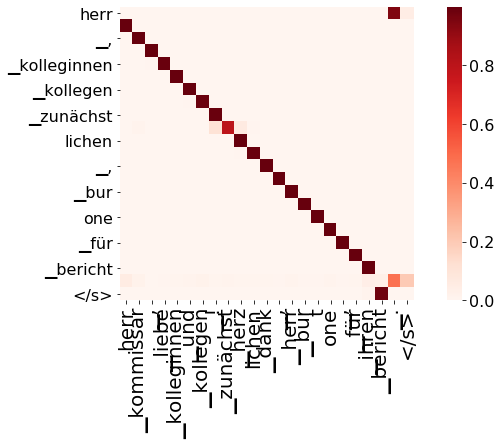

In [15]:
df = pd.DataFrame(attn_weights_heads_list[1][2].cpu().detach().numpy(),columns=source_tokens,index=source_tokens)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

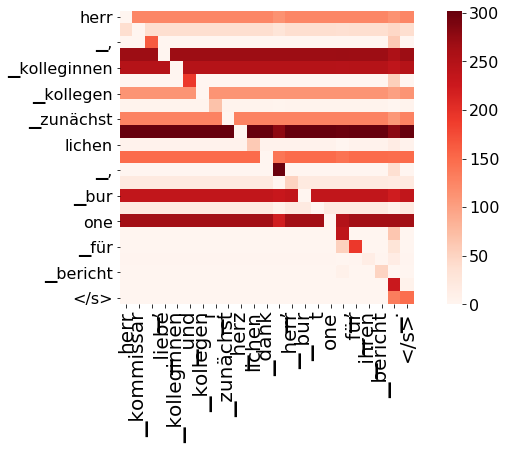

In [16]:
df = pd.DataFrame(normalized_contributions[0].cpu().detach().numpy(),columns=source_tokens,index=source_tokens)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

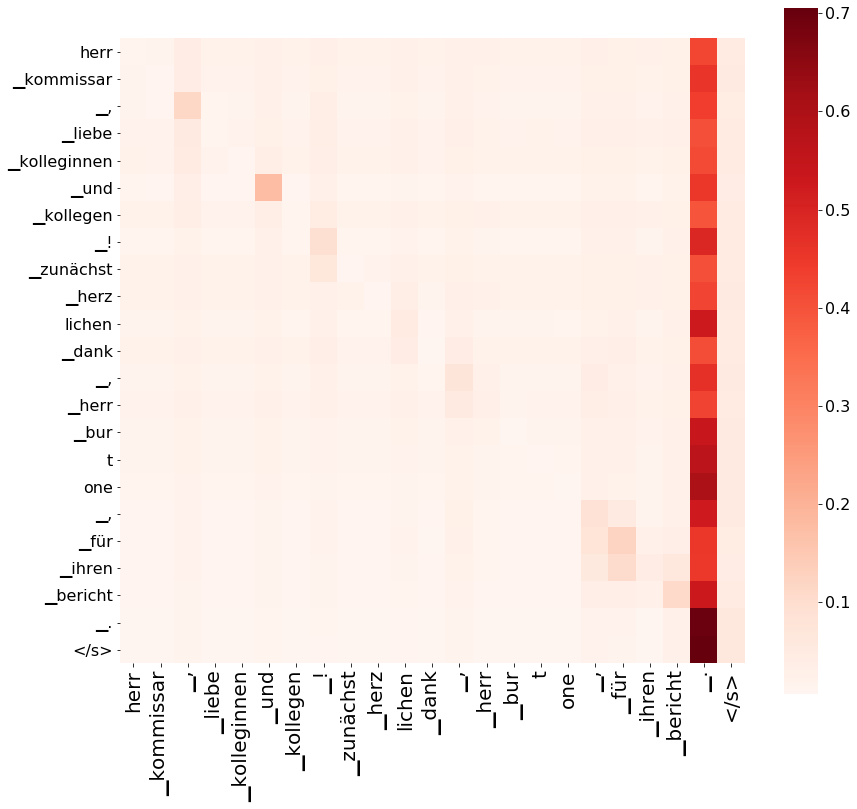

In [17]:
import networkx as nx
joint_attentions = compute_joint_attention(normalized_contributions,add_residual=False)
#joint_attentions = compute_attention_rollout(model_norms)
joint_attentions = joint_attentions.cpu().detach().numpy()
# joint_att_adjmat, joint_labels_to_index = get_adjmat(mat=joint_attentions, input_tokens=source_tokens)
joint_attention_layer = -1

#joint_attention_normalized_layer = joint_attentions[joint_attention_layer] / joint_attentions[joint_attention_layer].sum(axis=-1)[...,None]

fig, ax = plt.subplots(figsize =(14, 14))
df = pd.DataFrame(joint_attentions[joint_attention_layer],columns=source_tokens,index=source_tokens)
sns.heatmap(df,cmap="Reds",square=True,ax=ax)
plt.gcf().subplots_adjust(bottom=0.2)

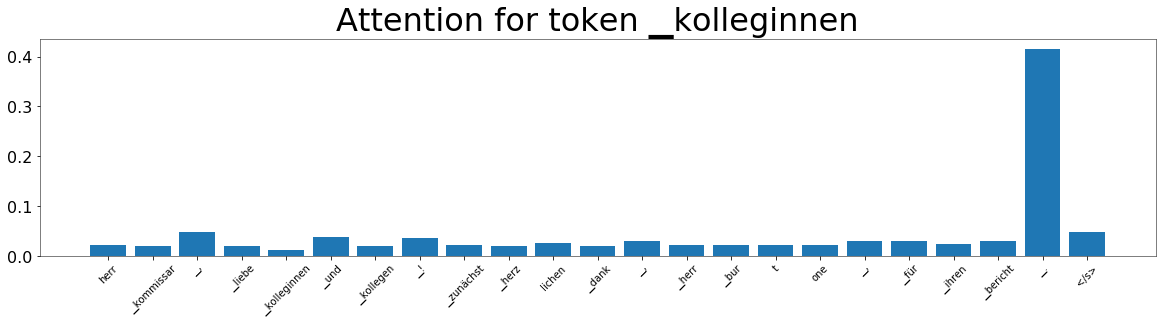

In [18]:
position = 4
# Creating plot
fig = plt.figure(figsize =(20, 4)) 
ax = fig.add_subplot(111) 
ax.bar(np.arange(0,len(source_tokens)),joint_attentions[layer][position])
ax.set_xticks(range(0,len(source_tokens)))
#ax.boxplot(attn_output_vectors);
ax.set_title('Attention for token ' + str(source_tokens[position]))
ax.set_xticklabels(source_tokens, rotation=45, fontsize=10);

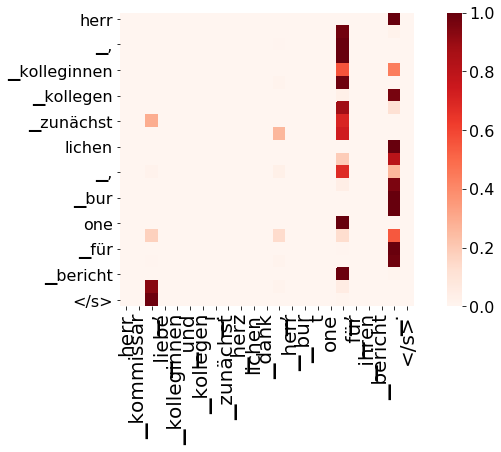

In [19]:

df = pd.DataFrame(attn_weights_heads_list[0][3].cpu().detach().numpy(),columns=source_tokens,index=source_tokens)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

## Similarity with same token at different layers

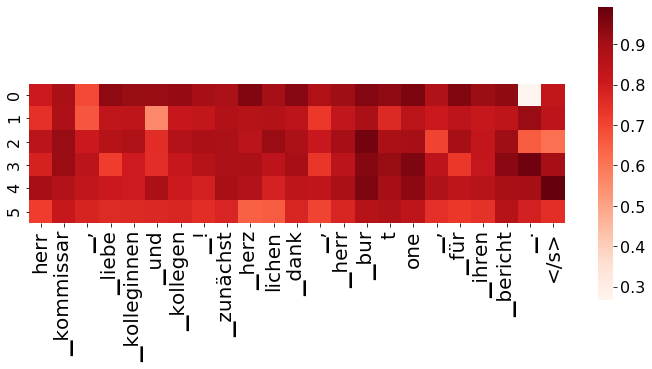

In [21]:
pos = 0
hidden_state_position = []

#fig, ax = plt.subplots(figsize =(14, 14))


for layer in range(num_layers+1):
    hidden_states = torch.squeeze(encoder_out['encoder_states'][layer])
    hidden_state_position.append(hidden_states)

hidden_state_position_stack = torch.stack(hidden_state_position)
similarities_numpy = np.zeros((num_layers, hidden_state_position_stack.size(1)))

cos = nn.CosineSimilarity(dim=0, eps=1e-6)

for layer in range(1,num_layers+1):
    for pos in range(len(source_tokens)):
        output = cos(hidden_state_position_stack[layer][pos], hidden_state_position_stack[layer-1][pos])
        similarities_numpy[layer-1,pos] = output

df = pd.DataFrame(similarities_numpy,columns=source_tokens,index=range(0,num_layers))
sns.heatmap(df,cmap="Reds",square=True)
#ax.set_xticklabels(source_tokens, rotation=45, fontsize=6);
plt.gcf().subplots_adjust(bottom=0.2)


## Similarity with final punctuation mark token

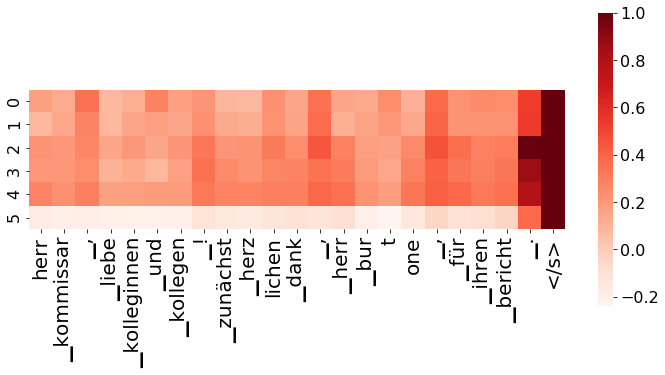

In [22]:
pos = 0
hidden_state_position = []

#fig, ax = plt.subplots(figsize =(14, 14))


for layer in range(num_layers+1):
    hidden_states = torch.squeeze(encoder_out['encoder_states'][layer])
    hidden_state_position.append(hidden_states)

hidden_state_position_stack = torch.stack(hidden_state_position)
similarities_numpy = np.zeros((num_layers, hidden_state_position_stack.size(1)))

cos = nn.CosineSimilarity(dim=0, eps=1e-6)

for layer in range(1,num_layers+1):
    for pos in range(len(source_tokens)):
        output = cos(hidden_state_position_stack[layer][pos], hidden_state_position_stack[layer][-1])
        similarities_numpy[layer-1,pos] = output

df = pd.DataFrame(similarities_numpy,columns=source_tokens,index=range(0,num_layers))
sns.heatmap(df,cmap="Reds",square=True)
#ax.set_xticklabels(source_tokens, rotation=45, fontsize=6);
plt.gcf().subplots_adjust(bottom=0.2)


In [23]:
dense = model.models[0].encoder.layers[3].self_attn.out_proj.weight

print(dense[:,0:64].norm())
print(dense[:,64:129].norm())
print(dense[:,128:191].norm())
print(dense[:,192:].norm())

tensor(8.6928, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(8.8801, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(9.3188, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(18.3294, device='cuda:0', grad_fn=<CopyBackwards>)


In [24]:
layer = 3

v = model.models[0].encoder.layers[layer].self_attn.v_proj(in_self_attn_stack)
#v = v.contiguous().view(bsz, num_heads, -1, 1, head_dim).transpose(1, 2)
v = (
                v.contiguous()
                .view(-1, bsz * num_heads, head_dim)
                .transpose(0, 1)
            )

attn_weights_float = torch.squeeze(encoder_out['attn_weights'][0][layer])
attn_weights_heads_list.append(attn_weights_float)
attn = attn_weights_float.mean(dim=0)
attn_weights_list.append(attn)


# Dense weights W^O: (embed_dim, embed_dim)
dense = model.models[0].encoder.layers[layer].self_attn.out_proj.weight

# Reshape W^O into (num_heads, head_dim, embed_dim)
dense = dense.view(embed_dim, num_heads, head_dim).permute(1,2,0).contiguous()
#dense = dense.view(embed_dim, num_heads, head_dim).permute(1,0,2).contiguous()
# transformed_vectors = v.matmul(dense).view(bsz, -1, num_heads, embed_dim)
# transformed_vectors = transformed_vectors.permute(0, 2, 1, 3)

attn_probs = attn_weights_float.view(bsz*num_heads, src_len, src_len)


In [25]:
import copy

## Delete finalizing tokens and commas
deleted_values = [-1,-2]
source_tokens_trunc = copy.deepcopy(source_tokens)
tokens_to_remove = ['▁,','▁!']#▁,
for i, character in enumerate(source_tokens):
    if character in tokens_to_remove:
        deleted_values.append(i)

for token_to_remove in tokens_to_remove:
    while True:
        try:
            source_tokens_trunc = source_tokens_trunc[:source_tokens_trunc.index(token_to_remove)]+source_tokens_trunc[source_tokens_trunc.index(token_to_remove)+1:]
        except:
            break
source_tokens_trunc = source_tokens_trunc[:-2]


joint_attention_normalized_layer_trunc = np.delete(joint_attention_normalized_layer, deleted_values, 1)

joint_attention_normalized_layer_trunc = joint_attention_normalized_layer_trunc / joint_attention_normalized_layer_trunc.sum(axis=-1)[...,None]


fig, ax = plt.subplots(figsize =(14, 14))
df = pd.DataFrame(joint_attention_normalized_layer_trunc,columns=source_tokens_trunc,index=source_tokens)
sns.heatmap(df,cmap="Reds",square=True,ax=ax)
plt.gcf().subplots_adjust(bottom=0.2)

NameError: name 'joint_attention_normalized_layer' is not defined

## Check norms of values

In [ ]:
layer = 3
v = func_outputs['models.0.encoder.layers.' + str(layer) + '.self_attn.v_proj'][0]
v_joint=torch.squeeze(v)

v = get_cross_attention_projections_by_head(v,n_heads,embed_dim)
print(v.size())
transformed_vectors_box = v.norm(dim=2).data
transformed_vectors_box = transformed_vectors_box.permute(1,0).cpu()
print(transformed_vectors_box.size())
# Creating plot 
fig = plt.figure(figsize =(20, 5)) 
ax = fig.add_subplot(111)

ax.boxplot(transformed_vectors_box)
ax.set_title('Norm value vectors')
ax.set_xticks(range(1,len(source_tokens)+1))
ax.set_xticklabels(source_tokens, rotation=90, fontsize=16);
#ax.set_ylim([0,40])
#legend  = ax.legend(fontsize=14);